In [ ]:
#Imports

In [1]:
import pandas as pd
import numpy as np 
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
import math
import sklearn

#Loan data from CSV
df_orig_data = pd.read_csv("data.csv")
#Drop CAX_ID column
df_orig_data = df_orig_data.iloc[:,1:]

In [3]:
numerical_col_names = list(df_orig_data.select_dtypes(include=[np.number]).columns.values)
non_numerical_col_names = list(df_orig_data.select_dtypes(exclude=[np.number]).columns.values)

In [ ]:
#Plot a graph of the distribution of each numerical variable

In [28]:
for i in range(3): #len(numerical_col_names)
    
    a = df_orig_data.columns.get_loc(numerical_col_names[i])
    cut = pd.cut(df_orig_data[df_orig_data.columns[a]], bins=17)
    grouped_df = df_orig_data.groupby(cut)
    bins_with_count = np.array(grouped_df.size().reset_index())
    bins_only = bins_with_count[0:,0]
    count_only = bins_with_count[0:,1]
    output_file('vbar.html')
    p = figure(x_range=bins_only, plot_width=400, plot_height=400, title=numerical_col_names[i])
    p.vbar(x=bins_only, width=0.2, bottom=0, top=count_only, color="firebrick")
    p.xaxis.major_label_orientation = math.pi/2
    show(p)

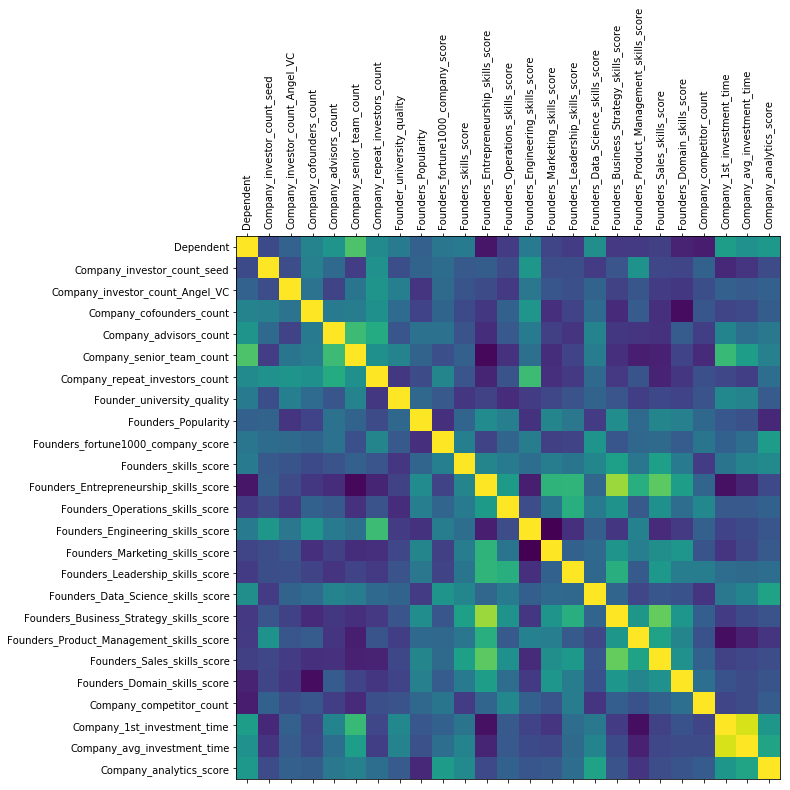

In [5]:
import matplotlib.pyplot as plt

corr_mat = df_orig_data.corr()

def plot_corr(df,size=10):

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.show()
    
plot_corr(corr_mat)

In [6]:
# Get top correlated variables

In [10]:
corr_abs = df_orig_data.corr().abs()
corr_abs_unstk = corr_abs.unstack()
corr_abs_unstk_ordered = corr_abs_unstk.sort_values(kind="quicksort", ascending = False)
print (corr_abs_unstk_ordered)

Company_analytics_score                   Company_analytics_score                     1.000000
Founders_Entrepreneurship_skills_score    Founders_Entrepreneurship_skills_score      1.000000
Company_competitor_count                  Company_competitor_count                    1.000000
Founders_Domain_skills_score              Founders_Domain_skills_score                1.000000
Founders_Sales_skills_score               Founders_Sales_skills_score                 1.000000
Founders_Product_Management_skills_score  Founders_Product_Management_skills_score    1.000000
Founders_Business_Strategy_skills_score   Founders_Business_Strategy_skills_score     1.000000
Founders_Data_Science_skills_score        Founders_Data_Science_skills_score          1.000000
Founders_Leadership_skills_score          Founders_Leadership_skills_score            1.000000
Founders_Marketing_skills_score           Founders_Marketing_skills_score             1.000000
Founders_Engineering_skills_score         Founders

In [11]:
#Create dummi variables

In [12]:
cat_vars = non_numerical_col_names
data = df_orig_data
for i in range(len(non_numerical_col_names)):
    
    cat_list = pd.get_dummies(data.loc[:,non_numerical_col_names[i]], prefix = non_numerical_col_names[i])
    data1 = pd.concat([data, cat_list], axis=1)
    data = data1
    
cat_vars = non_numerical_col_names
data_vars = data.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]
data_final = data[to_keep]
data_final_vars = data.columns.values.tolist()
y = ['Dependent']
X = [i for i in data_final if i not in y]

data_final = data[X]
y_final = data[y]

In [13]:
#Perform RFE

In [14]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
num_features = 40
rfe = RFE(logreg, num_features)
rfe = rfe.fit(data_final, y_final)

#Create a list of column names for features selected by RFE
data_final_col_names = data_final.columns.values
rfe_list = list(rfe.support_)
col_names_final = []
for i in range(len(data_final_col_names)):
    
    if(rfe_list[i] == True):
        
        col_names_final.append(data_final_col_names[i])

X = data_final.loc[:,col_names_final]
Y = y_final

C:\Users\stoian\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
# Split randomly into test and train cases

In [20]:
np.random.seed(123)
msk = np.random.rand(len(data_final)) < 0.8

X_Train = X[msk]
Y_Train = Y[msk]

X_Test = X[~msk]
Y_Test = Y[~msk]

In [21]:
# Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_Train, Y_Train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
y_pred = logreg.predict(X_Test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_Test, Y_Test)))

Accuracy of logistic regression classifier on test set: 0.70


In [24]:
#Cross-validation on logistic reg

In [25]:
logreg = LogisticRegression()
from pandas import ExcelWriter

k = 5
a = len(X)/k
test_start = -a
train_len = len(X)
total_score = []
for i in range(k):
    
    test_start = test_start + a
    test_end = test_start + a
    if train_len - test_end < a :
        test_end = train_len
        
    train_01_start = 0
    train_02_start = test_end
    train_01_end = test_start
    train_02_end = train_len
    
    if test_end == train_len :
        train_02_end = test_start
    
    X_Train_01 = X.iloc[train_01_start:train_01_end,:]
    X_Train_02 = X.iloc[train_02_start:train_02_end,:]
    X_Train = X_Train_01.append(X_Train_02,ignore_index=True)
    Y_Train_01 = Y.iloc[train_01_start:train_01_end,:]
    Y_Train_02 = Y.iloc[train_02_start:train_02_end,:]
    Y_Train = Y_Train_01.append(Y_Train_02,ignore_index=True)
    X_Test = X.iloc[test_start:test_end,:]
    Y_Test = Y.iloc[test_start:test_end,:]

    writer = ExcelWriter("LogReg_CrossVal_X_Train" + str(i) + ".xlsx")
    X_Train.to_excel(writer,str(i))
    writer.save()
    writer = ExcelWriter("LogReg_CrossVal_Y_Train" + str(i) + ".xlsx")
    Y_Train.to_excel(writer,str(i))
    writer.save()
    writer = ExcelWriter("LogReg_CrossVal_X_Test" + str(i) + ".xlsx")
    X_Test.to_excel(writer,str(i))
    writer.save()
    writer = ExcelWriter("LogReg_CrossVal_Y_Test" + str(i) + ".xlsx")
    Y_Test.to_excel(writer,str(i))
    writer.save()
    
    logreg.fit(X_Train, Y_Train)
    score = logreg.score(X_Test, Y_Test)
    total_score.append(score)

score_overall = sum(total_score)/len(total_score)
print('Accuracy of logistic regression classifier over all sets: {:.2f}', score_overall)
    

('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.56695652173913047)


In [ ]:
#Iteratively increase number of features returned by RFE and see effect on logistic regression

In [27]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

result = []
for j in range(79): #len(list(data_final.columns.values))
    
    logreg = LogisticRegression()
    num_features = j+1
    rfe = RFE(logreg, num_features)
    rfe = rfe.fit(data_final, y_final)

    #Create a list of column names for features selected by RFE
    data_final_col_names = data_final.columns.values
    rfe_list = list(rfe.support_)
    col_names_final = []
    for i in range(len(data_final_col_names)):

        if(rfe_list[i] == True):
            col_names_final.append(data_final_col_names[i])


    X = data_final.loc[:,col_names_final]
    Y = y_final

    
    logreg = LogisticRegression()
    from pandas import ExcelWriter

    k = 5
    a = len(X)/k
    test_start = -a
    train_len = len(X)
    total_score = []
    for i in range(k):

        test_start = test_start + a
        test_end = test_start + a
        if train_len - test_end < a :
            test_end = train_len
    #     print start, end
        train_01_start = 0
        train_02_start = test_end
        train_01_end = test_start
        train_02_end = train_len

        if test_end == train_len :
            train_02_end = test_start

        X_Train_01 = X.iloc[train_01_start:train_01_end,:]
        X_Train_02 = X.iloc[train_02_start:train_02_end,:]
        X_Train = X_Train_01.append(X_Train_02,ignore_index=True)
        Y_Train_01 = Y.iloc[train_01_start:train_01_end,:]
        Y_Train_02 = Y.iloc[train_02_start:train_02_end,:]
        Y_Train = Y_Train_01.append(Y_Train_02,ignore_index=True)
        X_Test = X.iloc[test_start:test_end,:]
        Y_Test = Y.iloc[test_start:test_end,:]

        logreg.fit(X_Train, Y_Train)
        score = logreg.score(X_Test, Y_Test)
        total_score.append(score)

    score_overall = sum(total_score)/len(total_score)
    result.append([num_features,score_overall])
    print('Accuracy of logistic regression classifier over all sets: {:.2f}', score_overall)

('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.63565217391304341)
('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.53130434782608693)
('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.64399999999999991)
('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.52347826086956517)
('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.52817391304347827)
('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.58469565217391306)
('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.52817391304347827)
('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.53217391304347827)
('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.56660869565217387)
('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.56660869565217387)
('Accuracy of logistic regression classifier over all sets: {:.2f}', 0.59408695652173904)
('Accuracy

In [26]:
from sklearn import svm
clf = svm.SVC()

k = 5
a = len(X)/k
test_start = -a
train_len = len(X)
total_score = []
for i in range(k):
    
    test_start = test_start + a
    test_end = test_start + a
    if train_len - test_end < a :
        test_end = train_len

    train_01_start = 0
    train_02_start = test_end
    train_01_end = test_start
    train_02_end = train_len
    
    if test_end == train_len :
        train_02_end = test_start
    
    print (train_01_start, train_01_end)
    print (train_02_start, train_02_end)
    
    X_Train_01 = X.iloc[train_01_start:train_01_end,:]
    X_Train_02 = X.iloc[train_02_start:train_02_end,:]
    X_Train = X_Train_01.append(X_Train_02,ignore_index=True)
    Y_Train_01 = Y.iloc[train_01_start:train_01_end,:]
    Y_Train_02 = Y.iloc[train_02_start:train_02_end,:]
    Y_Train = Y_Train_01.append(Y_Train_02,ignore_index=True)
    X_Test = X.iloc[test_start:test_end,:]
    Y_Test = Y.iloc[test_start:test_end,:]
    
    clf.fit(X_Train, Y_Train) 
    score = clf.score(X_Test, Y_Test)
    total_score.append(score)
    print('Accuracy of SVM classifier on test set: {:.2f}',score)

score_overall = sum(total_score)/len(total_score)
print('Accuracy of SVM classifier over all sets: {:.2f}', score_overall)
    

(0, 0)
(46, 234)
('Accuracy of SVM classifier on test set: {:.2f}', 0.65217391304347827)
(0, 46)
(92, 234)
('Accuracy of SVM classifier on test set: {:.2f}', 0.47826086956521741)
(0, 92)
(138, 234)
('Accuracy of SVM classifier on test set: {:.2f}', 0.47826086956521741)
(0, 138)
(184, 234)
('Accuracy of SVM classifier on test set: {:.2f}', 0.82608695652173914)
(0, 184)
(234, 184)
('Accuracy of SVM classifier on test set: {:.2f}', 0.38)
('Accuracy of SVM classifier over all sets: {:.2f}', 0.56295652173913047)
